# Network Attack Detection using Machine Learning
## Project goal

The goal of this project is to build a machine learning model that is able to detect and classify network attacks. The model will be trained using a dataset of network flows, and will be able to predict if a new flow is an attack or not, and if it is, what kind of attack it is.

## Dataset description

The dataset used for this project is written in the NetFlow V9 format (format by Cisco, documentation available [here](https://www.cisco.com/en/US/technologies/tk648/tk362/technologies_white_paper09186a00800a3db9.html)). The dataset is composed by two files:

* **train_set**: ~2 million flows, used for training the model
* **test_set**: ~4 million flows, used for testing the model

### Columns
* **FLOW_ID**: A unique identifier for the flow
* **PROTOCOL_MAP**: A string representing the protocol used in the flow, possible values include "ICMP", "TCP", "UDP", "IGMP", "GRE", "ESP", "AH", "EIGRP", "OSPF", "PIM", "IPV6-ICMP", "IPV6-IP", "IPV6-ROUTE", "IPV6-FRAG", "IPV6-NONXT", "IPV6-OPTS", and others.
* **L4_SRC_PORT**: The source port number in the flow, possible values range from 0 to 65535.
* **IPV4_SRC_ADDR**: The source IPv4 address in the flow, represented as a string in dotted decimal notation (e.g., "192.168.0.1").
* **L4_DST_PORT**: The destination port number in the flow, possible values range from 0 to 65535.
* **IPV4_DST_ADDR**: The destination IPv4 address in the flow, represented as a string in dotted decimal notation (e.g., "192.168.0.2").
* **FIRST_SWITCHED**: The time at which the flow started, measured in seconds since the epoch (January 1, 1970).
* **FLOW_DURATION_MILLISECONDS**: The duration of the flow in milliseconds.
* **LAST_SWITCHED**: The time at which the flow ended, measured in seconds since the epoch (January 1, 1970).
* **PROTOCOL**: The protocol used in the flow, possible values include 1 (ICMP), 6 (TCP), 17 (UDP), and others.
* **TCP_FLAGS**: The TCP flags set in the flow, represented as a binary string (e.g., "100101").
* **TCP_WIN_MAX_IN**: The maximum advertised window size (in bytes) for incoming traffic.
* **TCP_WIN_MAX_OUT**: The maximum advertised window size (in bytes) for outgoing traffic.
* **TCP_WIN_MIN_IN**: The minimum advertised window size (in bytes) for incoming traffic.
* **TCP_WIN_MIN_OUT**: The minimum advertised window size (in bytes) for outgoing traffic.
* **TCP_WIN_MSS_IN**: The maximum segment size (in bytes) for incoming traffic.
* **TCP_WIN_SCALE_IN**: The window scale factor for incoming traffic.
* **TCP_WIN_SCALE_OUT**: The window scale factor for outgoing traffic.
* **SRC_TOS**: The Type of Service (ToS) value for the source IP address.
* **DST_TOS**: The Type of Service (ToS) value for the destination IP address.
* **TOTAL_FLOWS_EXP**: The total number of expected flows.
* **MIN_IP_PKT_LEN**: The minimum length (in bytes) of IP packets in the flow.
* **MAX_IP_PKT_LEN**: The maximum length (in bytes) of IP packets in the flow.
* **TOTAL_PKTS_EXP**: The total number of expected packets in the flow.
* **TOTAL_BYTES_EXP**: The total number of expected bytes in the flow.
* **IN_BYTES**: The number of bytes received in the flow.
* **IN_PKTS**: The number of packets received in the flow.
* **OUT_BYTES**: The number of bytes sent in the flow.
* **OUT_PKTS**: The number of packets sent in the flow.
* **ANALYSIS_TIMESTAMP**: The time at which the flow was analyzed, measured in seconds since the epoch (January 1, 1970).
* **ANOMALY**: A binary flag indicating whether the flow contains an anomaly (1 = true, 0 = false).
* **ALERT**: (<u>only available in training set</u>) The kind of attack that has been detected on the current flow. This are the possible values:
  - **None**: No attack has been detected

  - **Port scanning**: The flow is a port scanning attack 
  - **Denial of Service**: The flow is a DoS attack
  - **Malware**: The flow is a malware attack
* **ID**: A unique identifier for the flow.

## Tested models

* K-Nearest Neighbors (KNN)
* Support Vector Machine Classifier (SVC) with RBF (Radial Basis Function) kernel
* Pipeline with Principal Component Analysis (PCA) and Support Vector Machine Classifier (SVC)
* Bagging Classifier (based on SVC with RBF kernel)
* Random Forest Classifier
* Neural Network (MLPClassifier)

## 1. Datasets loading

In this section we load the datasets and, since the dataset is too big, we take a sample of it if in development mode.

### 1.1. Importing the basic libraries

In [1]:
# Load data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

### 1.2. Importing machine learning libraries

In [100]:
# Load machine learning libraries
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

### 1.3. Development mode flag

If the following flag is set to `True`, the model will be trained on a smaller dataset, in order to speed up the development process. If the flag is set to `False`, the model will be trained on the whole dataset.

In [3]:
# If true, only the 3% of the data will be used for training and testing of the various models
_DEVMODE = True

### 1.4. Loading the datasets

In [4]:
# Loading the data from the train and test files
train_df = pd.read_csv('data/train_net.csv')
test_df = pd.read_csv('data/test_net.csv')

### 1.5. Loaded datasets information

In [5]:
# Print total size
print("Test set size: ", test_df.shape)
print("Train set size: ", train_df.shape)

# Value counts
train_df['ALERT'].value_counts()

Test set size:  (2077339, 32)
Train set size:  (4217625, 33)


None                 3659000
Port Scanning         507845
Denial of Service      50392
Malware                  388
Name: ALERT, dtype: int64

### 1.6. Dataset development mode reduction

In [6]:
if _DEVMODE:
    train_df = train_df.sample(frac=0.03, random_state=1)
    test_df = test_df.sample(frac=0.03, random_state=1)

    # Print total size
    print("Test set size: ", test_df.shape)
    print("Train set size: ", train_df.shape)


Test set size:  (62320, 32)
Train set size:  (126529, 33)


## 2. Data preprocessing

In this section we preprocess the datasets in order to make them usable by the machine learning algorithms.

### 2.1. Print datasets information

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126529 entries, 1283232 to 959711
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FLOW_ID                     126529 non-null  int64  
 1   PROTOCOL_MAP                126529 non-null  object 
 2   L4_SRC_PORT                 126529 non-null  int64  
 3   IPV4_SRC_ADDR               126529 non-null  object 
 4   L4_DST_PORT                 126529 non-null  int64  
 5   IPV4_DST_ADDR               126529 non-null  object 
 6   FIRST_SWITCHED              126529 non-null  int64  
 7   FLOW_DURATION_MILLISECONDS  126529 non-null  int64  
 8   LAST_SWITCHED               126529 non-null  int64  
 9   PROTOCOL                    126529 non-null  int64  
 10  TCP_FLAGS                   126529 non-null  int64  
 11  TCP_WIN_MAX_IN              126529 non-null  int64  
 12  TCP_WIN_MAX_OUT             126529 non-null  int64  
 13  TCP_WIN_

### 2.2. Print datasets shape

In [8]:
# Show information about the data
def printInfo(df):
    print('Dataframe shape: ', df.shape)
    print('Dataframe columns: ', df.columns)

print('==== Train data ====')
printInfo(train_df)
print()
print('==== Test data ====')
printInfo(test_df)

==== Train data ====
Dataframe shape:  (126529, 33)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN',
       'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN', 'TCP_WIN_SCALE_IN',
       'TCP_WIN_SCALE_OUT', 'SRC_TOS', 'DST_TOS', 'TOTAL_FLOWS_EXP',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'TOTAL_PKTS_EXP', 'TOTAL_BYTES_EXP',
       'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'ANALYSIS_TIMESTAMP',
       'ANOMALY', 'ALERT', 'ID'],
      dtype='object')

==== Test data ====
Dataframe shape:  (62320, 32)
Dataframe columns:  Index(['FLOW_ID', 'PROTOCOL_MAP', 'L4_SRC_PORT', 'IPV4_SRC_ADDR',
       'L4_DST_PORT', 'IPV4_DST_ADDR', 'FIRST_SWITCHED',
       'FLOW_DURATION_MILLISECONDS', 'LAST_SWITCHED', 'PROTOCOL', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', '

### 2.3. Show training dataset structure

In [9]:
train_df.head()

,FLOW_ID,PROTOCOL_MAP,L4_SRC_PORT,IPV4_SRC_ADDR,L4_DST_PORT,IPV4_DST_ADDR,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LAST_SWITCHED,PROTOCOL,...,TOTAL_PKTS_EXP,TOTAL_BYTES_EXP,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,ANALYSIS_TIMESTAMP,ANOMALY,ALERT,ID
1283232,372246818,tcp,62980,10.114.241.166,47736,10.114.224.117,1647766047,0,1647766047,6,...,0,0,44,1,40,1,1647766568,0.0,Port Scanning,1283232
3327778,372024895,udp,44246,10.114.227.143,53,10.114.226.5,1647761040,0,1647761040,17,...,0,0,73,1,121,1,1647761116,0.0,None,3327778
3341312,334833539,tcp,36150,10.114.225.212,5228,74.125.133.188,1647346083,144,1647346083,6,...,0,0,132,2,130,2,1647346141,NaN,None,3341312
1704357,369619889,tcp,33858,10.114.225.206,6443,10.114.232.94,1647693586,0,1647693586,6,...,0,0,60,1,0,0,1647693660,1.0,None,1704357
4163521,371759146,udp,48586,10.114.227.52,53,10.114.226.5,1647752706,0,1647752706,17,...,0,0,91,1,146,1,1647752852,0.0,None,4163521


### 2.4 Check for missing values

In [10]:
# Check for missing values
print('==== Train data ====')
print(train_df.isnull().sum())
print()
print('==== Test data ====')
print(test_df.isnull().sum())
print()

==== Train data ====
FLOW_ID                           0
PROTOCOL_MAP                      0
L4_SRC_PORT                       0
IPV4_SRC_ADDR                     0
L4_DST_PORT                       0
IPV4_DST_ADDR                     0
FIRST_SWITCHED                    0
FLOW_DURATION_MILLISECONDS        0
LAST_SWITCHED                     0
PROTOCOL                          0
TCP_FLAGS                         0
TCP_WIN_MAX_IN                    0
TCP_WIN_MAX_OUT                   0
TCP_WIN_MIN_IN                    0
TCP_WIN_MIN_OUT                   0
TCP_WIN_MSS_IN                    0
TCP_WIN_SCALE_IN                  0
TCP_WIN_SCALE_OUT                 0
SRC_TOS                           0
DST_TOS                           0
TOTAL_FLOWS_EXP                   0
MIN_IP_PKT_LEN                    0
MAX_IP_PKT_LEN                    0
TOTAL_PKTS_EXP                    0
TOTAL_BYTES_EXP                   0
IN_BYTES                          0
IN_PKTS                           0
OUT_BYT

### 2.5 Fill missing **ANOMALY** values

In [11]:
# Fill the missing ANOMALY values with 0 (no anomaly)
train_df['ANOMALY'].fillna(0, inplace=True)
test_df['ANOMALY'].fillna(0, inplace=True)

## 3. Data analysis

In this section we analyze the datasets in order to have a better understanding of the data.

### 3.1. Data types

In [12]:
train_df.dtypes

FLOW_ID                         int64
PROTOCOL_MAP                   object
L4_SRC_PORT                     int64
IPV4_SRC_ADDR                  object
L4_DST_PORT                     int64
IPV4_DST_ADDR                  object
FIRST_SWITCHED                  int64
FLOW_DURATION_MILLISECONDS      int64
LAST_SWITCHED                   int64
PROTOCOL                        int64
TCP_FLAGS                       int64
TCP_WIN_MAX_IN                  int64
TCP_WIN_MAX_OUT                 int64
TCP_WIN_MIN_IN                  int64
TCP_WIN_MIN_OUT                 int64
TCP_WIN_MSS_IN                  int64
TCP_WIN_SCALE_IN                int64
TCP_WIN_SCALE_OUT               int64
SRC_TOS                         int64
DST_TOS                         int64
TOTAL_FLOWS_EXP                 int64
MIN_IP_PKT_LEN                  int64
MAX_IP_PKT_LEN                  int64
TOTAL_PKTS_EXP                  int64
TOTAL_BYTES_EXP                 int64
IN_BYTES                        int64
IN_PKTS     

### 3.2. Observing the distribution of the target variable

We can observe that the dataset is highly imbalanced, with the majority of the flows being normal (no attack detected). We can also observe that also the number of malware attacks is very low, compared to the other attacks.

These two facts will have a big impact on the model training, as we will see later.

<Axes: xlabel='ALERT', ylabel='count'>

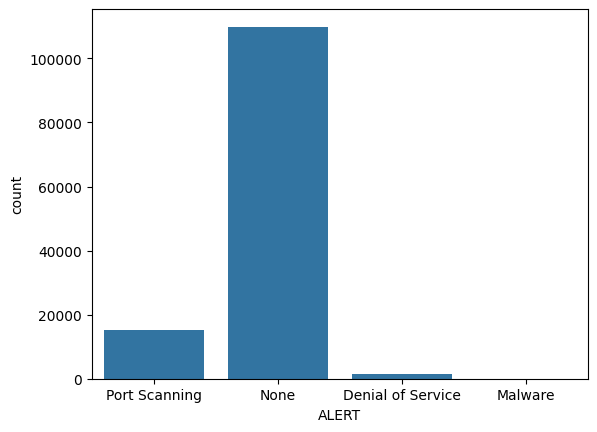

In [13]:
# Show the distribution of the target variable
sns.countplot(x='ALERT', data=train_df)

In [14]:
# Count the number of unique protocol_maps
train_df['PROTOCOL_MAP'].value_counts()

tcp          62514
udp          54250
icmp          9728
gre             36
ipv6-icmp        1
Name: PROTOCOL_MAP, dtype: int64

[Text(0.5, 1.0, 'L4_SRC_PORT')]

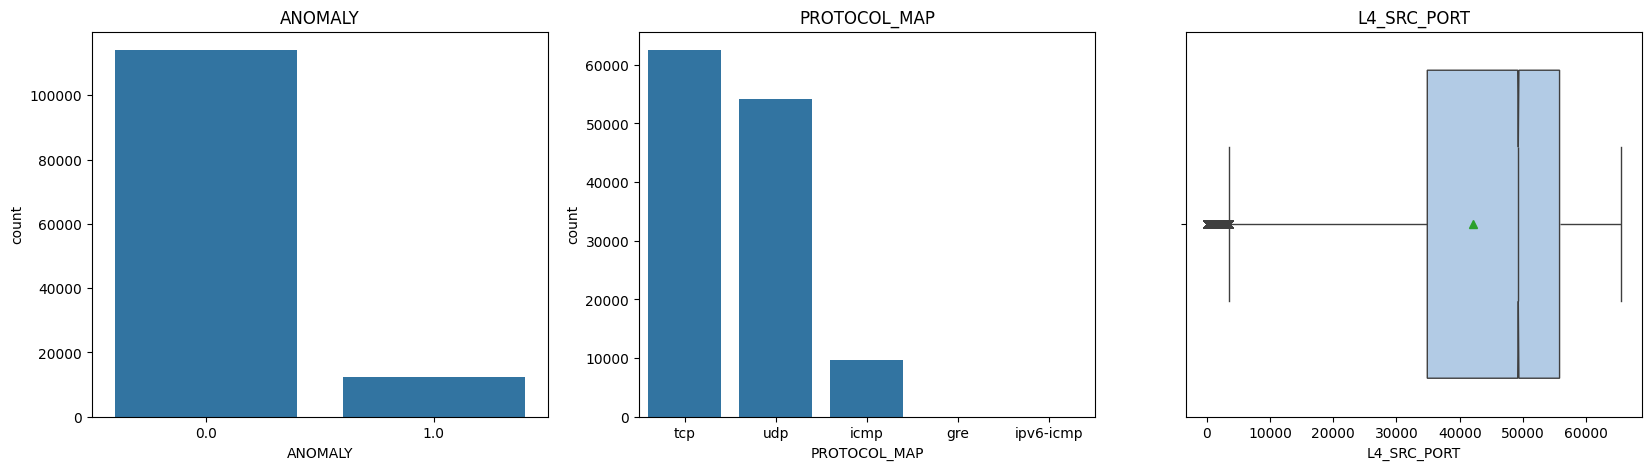

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# seaborn countplots
sns.countplot(x='ANOMALY', data=train_df, ax=axs[0]).set(title='ANOMALY')
              

# Seaborn countplot for the 'PROTOCOL_MAP' column, with enough space for the labels
sns.countplot(x='PROTOCOL_MAP', data=train_df, ax=axs[1]).set(title='PROTOCOL_MAP')

# Boxplot for L4_SRC_PORT to undestand the distribution of the data
sns.boxplot(
    x='L4_SRC_PORT', data=train_df, ax=axs[2],
    notch=True, showcaps=True,
    flierprops={"marker": "x"}, # Change the outlier marker
    showmeans=True, # Show the mean
    boxprops={"facecolor": (.4, .6, .8, .5)},
  ).set(title='L4_SRC_PORT')

### 3.3. Protocol distribution in relation to the kind of attack

<Axes: xlabel='PROTOCOL_MAP', ylabel='count'>

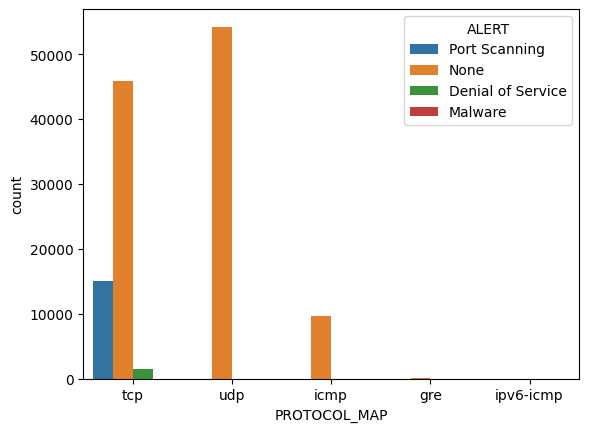

In [16]:
# Show protocol_map distribution for kind of ALERT
sns.countplot(x='PROTOCOL_MAP', hue='ALERT', data=train_df)

### 3.4. Unique hosts in dataset

Knowing the amount of unique hosts in the dataset is important to understand the size of the dataset since we expect that a bigger dataset will be more difficult to train properly.

In [17]:
# Find unique hosts (IP addresses) in the train and test data
train_src_hosts = train_df['IPV4_SRC_ADDR'].unique()
train_dst_hosts = train_df['IPV4_DST_ADDR'].unique()
train_hosts = np.union1d(train_src_hosts, train_dst_hosts)

# For each host, count the number of flows
print('Number of unique hosts in the train data: ', len(train_hosts))

# Find unique hosts (IP addresses) in the train and test data
test_src_hosts = test_df['IPV4_SRC_ADDR'].unique()
test_dst_hosts = test_df['IPV4_DST_ADDR'].unique()
test_hosts = np.union1d(test_src_hosts, test_dst_hosts)

# Floor ratio of hosts in test data that are not in train data
ratio = math.floor((1.0-len(test_hosts)/len(train_hosts)) * 100)

# For each host, count the number of flows
print("Number of unique hosts in the test data: {} (~{}% smaller)".format(len(test_hosts), ratio))


Number of unique hosts in the train data:  16875
Number of unique hosts in the test data: 11085 (~34% smaller)


### 3.5. Distribution analysis using pairplot

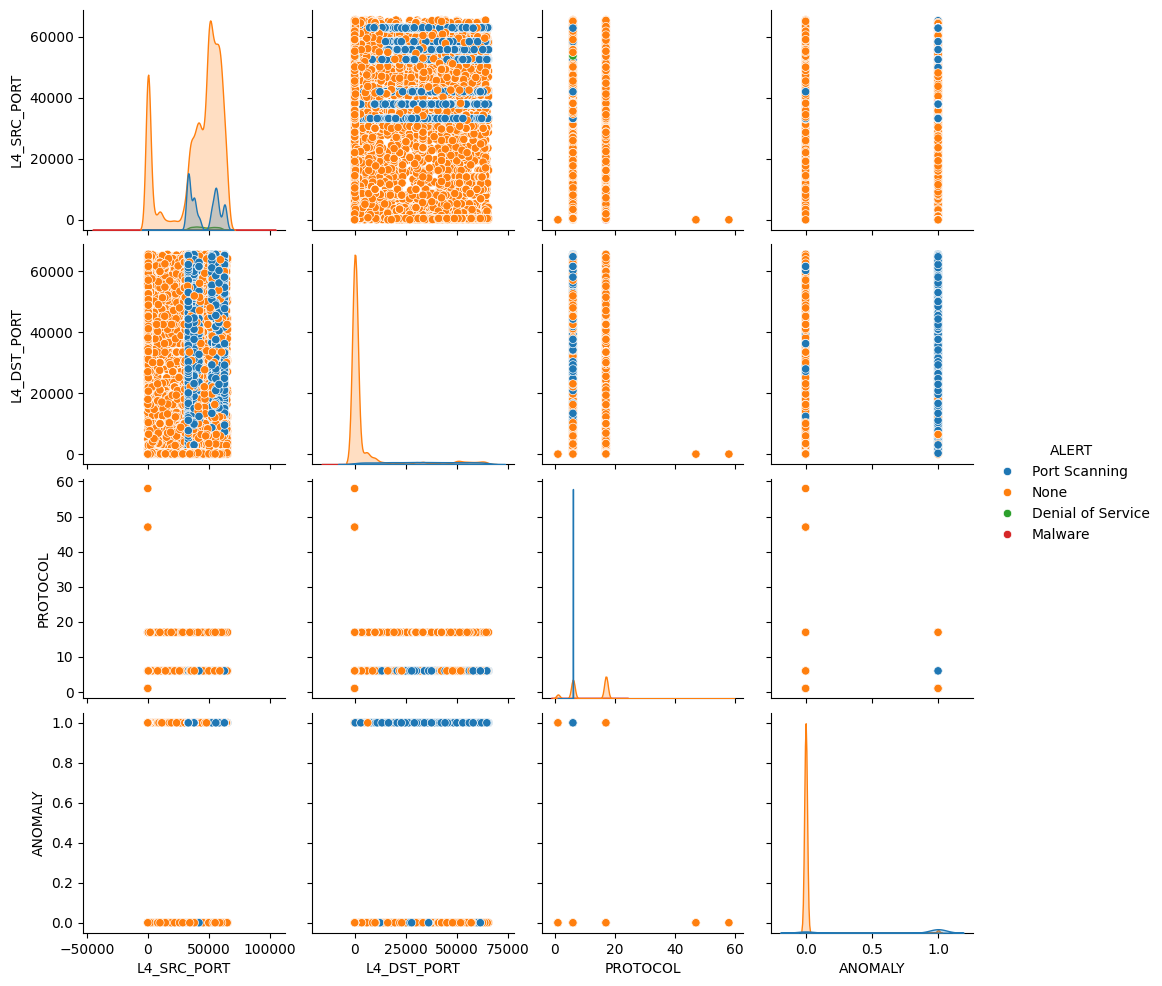

In [21]:
# select the columns to be used for training
train_df_columns = train_df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'ANOMALY', 'ALERT']]

# Distribution analysis using pairplot
sns.pairplot(train_df_columns, hue='ALERT')

### 3.6. Remove useless columns and create dummies

In [19]:
# Revoked columns
revoked_columns = [
  'FLOW_ID', # Completely random
  'ID', # Completely random
  'ANALYSIS_TIMESTAMP', # Completely random
  'IPV4_SRC_ADDR', # Not useful for the model
  'IPV4_DST_ADDR', # Not useful for the model
  'PROTOCOL_MAP', # There is a numerical column for the protocol
  'MIN_IP_PKT_LEN', # Always 0 since it is a minimum value
  'MAX_IP_PKT_LEN', # Always 0 (maybe it means that the packet have infinite length?)
  'TOTAL_PKTS_EXP', # Always 0
  'TOTAL_BYTES_EXP', # Always 0
]

# Create dummy columns for the ALERT column
alert_dummies = pd.get_dummies(train_df['ALERT'], prefix='ALERT', drop_first=True)

# Copy + drop the revoked columns
train_df = train_df.copy().drop(revoked_columns, axis=1)

### 3.7. Correlation heatmap

We can observe that there are some features that are highly correlated with each other, such as **IN_BYTES** - **OUT_BYTES** and **IN_PKTS** - **OUT_PKTS**. This is not surprising, since these features are related to the amount of data exchanged between the two hosts.

We can also observe that a *port scanning* alert is highly correlated with the **L4_DST_PORT** and **ANOMALY** features. This is not surprising, since a port scanning attack is a type of attack that tries to find open ports on a host. It is highly correlated with **ANOMALY** probably because the forged packets are built in a way that they are not recognized as an attack by the network.

Unfortunately, since *malware attacks* alerts are various and have different characteristics/features, it is not possible to find a correlation between them and the other features. This could mean that the features used in this dataset are not enough to detect malware attacks.

In the other hand, *none* alerts are strongly negatively correlated with **ANOMALY** and **L4_DST_PORT**. This is not surprising, since a normally a flow contains valid packets and the destination is usually a well-known port.

<Axes: >

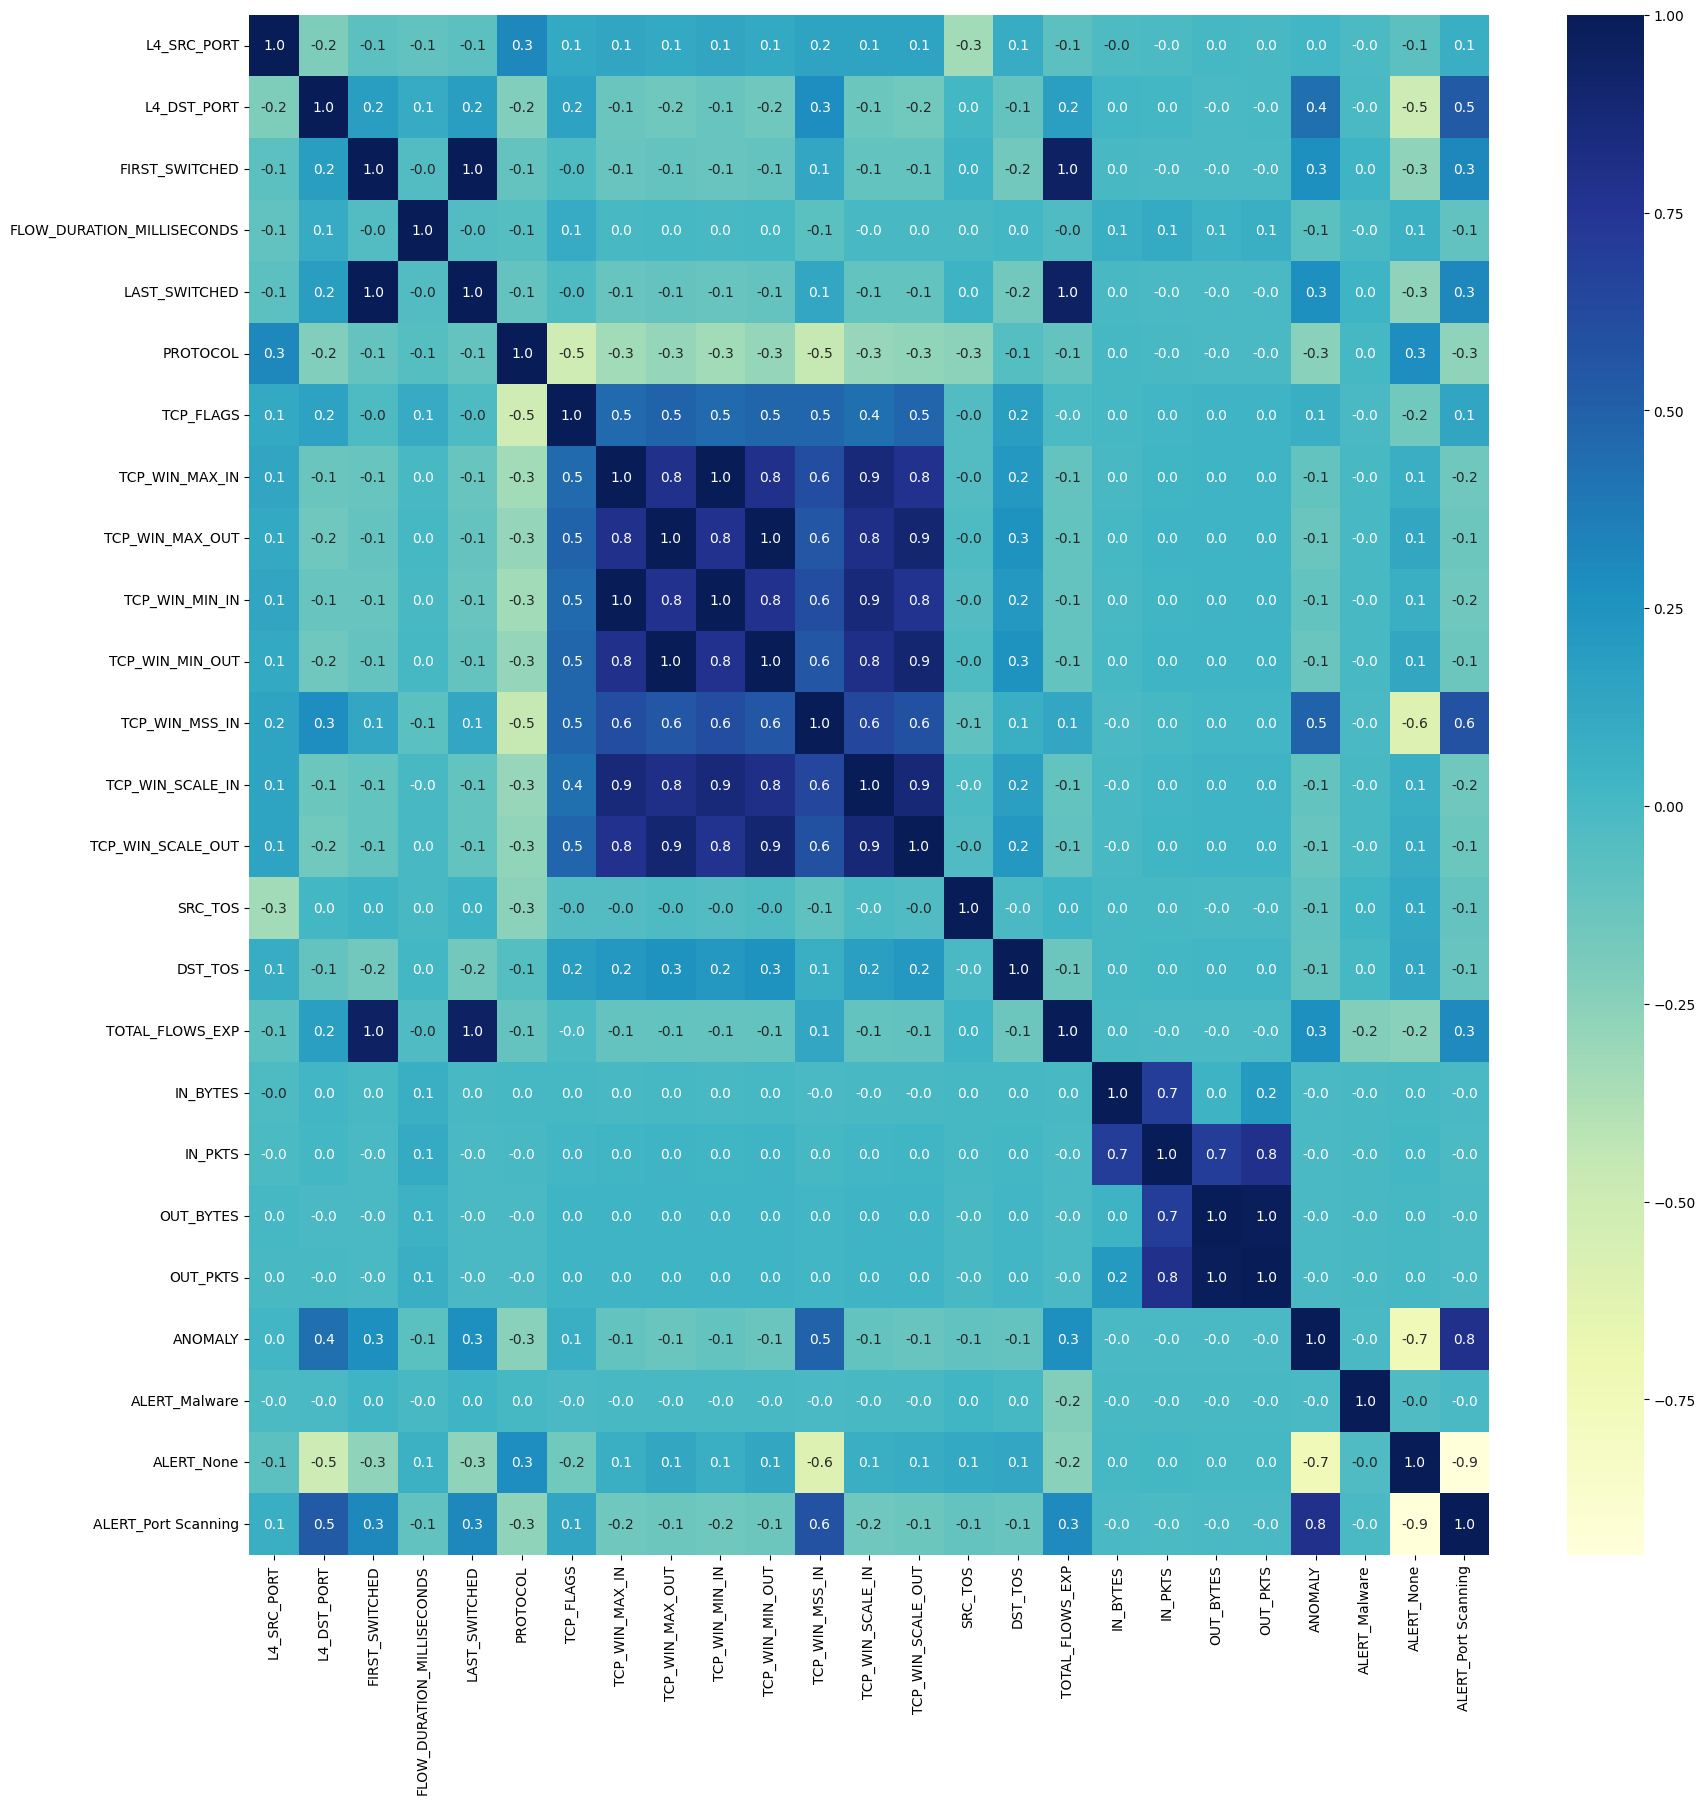

In [20]:
# Correlation heatmap using pandas
corr = pd.concat([train_df.drop('ALERT', axis=1), alert_dummies], axis=1).corr(
  numeric_only=False, # Only consider numeric columns
)

# Correlation heatmap using seaborn + make annotations fit the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")

## 4. Dataset preparation

In this section we prepare the dataset for the machine learning algorithms. We will split the dataset into training and testing sets, and we will also scale the data to make it more suitable for the algorithms.


### 4.1. Splitting the training set

Since we already have a test set, we split our training set in training and validation sets. We will use Sklearn's `StratifiedShuffleSplit` to split the training set in 80% training and 20% validation maintaining the same distribution of the target variable. This is needed since the dataset is highly imbalanced.

In [22]:
def split_maintain_distribution(X, y):
  sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=9)
  indexes = sss.split(X, y)
  train_indices, test_indices = next(indexes)
  return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

In [23]:
X_train, X_val, y_train, y_val = split_maintain_distribution(train_df.drop('ALERT', axis=1), train_df['ALERT'])

Now, check if actually the distribution of the target variable is the same in the training and validation sets.

#### 4.1.1 Check if the datasets are balanced

In [24]:
# Print distribution of the target variable in the train and validation sets
print('Train set distribution:')
print(y_train.value_counts(normalize=True))
print()
print('Validation set distribution:')
print(y_val.value_counts(normalize=True))

Train set distribution:
None                 0.868508
Port Scanning        0.119380
Denial of Service    0.011983
Malware              0.000128
Name: ALERT, dtype: float64

Validation set distribution:
None                 0.868490
Port Scanning        0.119379
Denial of Service    0.011973
Malware              0.000158
Name: ALERT, dtype: float64


We can confirm that the distribution of the target variable is the same in the training and validation sets.

### 4.2. Data scaling

Scaling the data is important to avoid that some features will have a bigger impact on the model training than others. This is especially important when we are dealing with features that have different units of measure.

In [25]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_validation_scaled = fitter.transform(X_val)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_validation = pd.DataFrame(x_validation_scaled, columns=X_val.columns)

## 5. Feature selection

In this section we will use a Random Forest classifier to find the most important features in the dataset. This will help us to reduce the number of features used in the model training, and therefore speed up the training process.

### 5.1. Create model and fit it

In [26]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100) # 100 trees = default value

# Fit the model
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier()

### 5.2. Get feature importances

In [27]:
# Print features importance
feature_importances = pd.DataFrame(
    rfc.feature_importances_,
    index=X_train.columns,
    columns=['importance']
).sort_values('importance', ascending=False)
print(feature_importances)

                            importance
IN_BYTES                      0.178223
TCP_WIN_MSS_IN                0.148047
ANOMALY                       0.097467
TCP_WIN_MAX_IN                0.092795
L4_DST_PORT                   0.079751
TCP_WIN_MIN_IN                0.077500
OUT_BYTES                     0.047480
TOTAL_FLOWS_EXP               0.041107
LAST_SWITCHED                 0.036021
FIRST_SWITCHED                0.031542
FLOW_DURATION_MILLISECONDS    0.029933
TCP_FLAGS                     0.026390
L4_SRC_PORT                   0.024088
TCP_WIN_MAX_OUT               0.022943
IN_PKTS                       0.016770
TCP_WIN_MIN_OUT               0.013684
TCP_WIN_SCALE_IN              0.009913
SRC_TOS                       0.008065
OUT_PKTS                      0.007961
TCP_WIN_SCALE_OUT             0.005308
PROTOCOL                      0.004058
DST_TOS                       0.000952


### 5.3. Plot feature importances

<Axes: xlabel='None', ylabel='importance'>

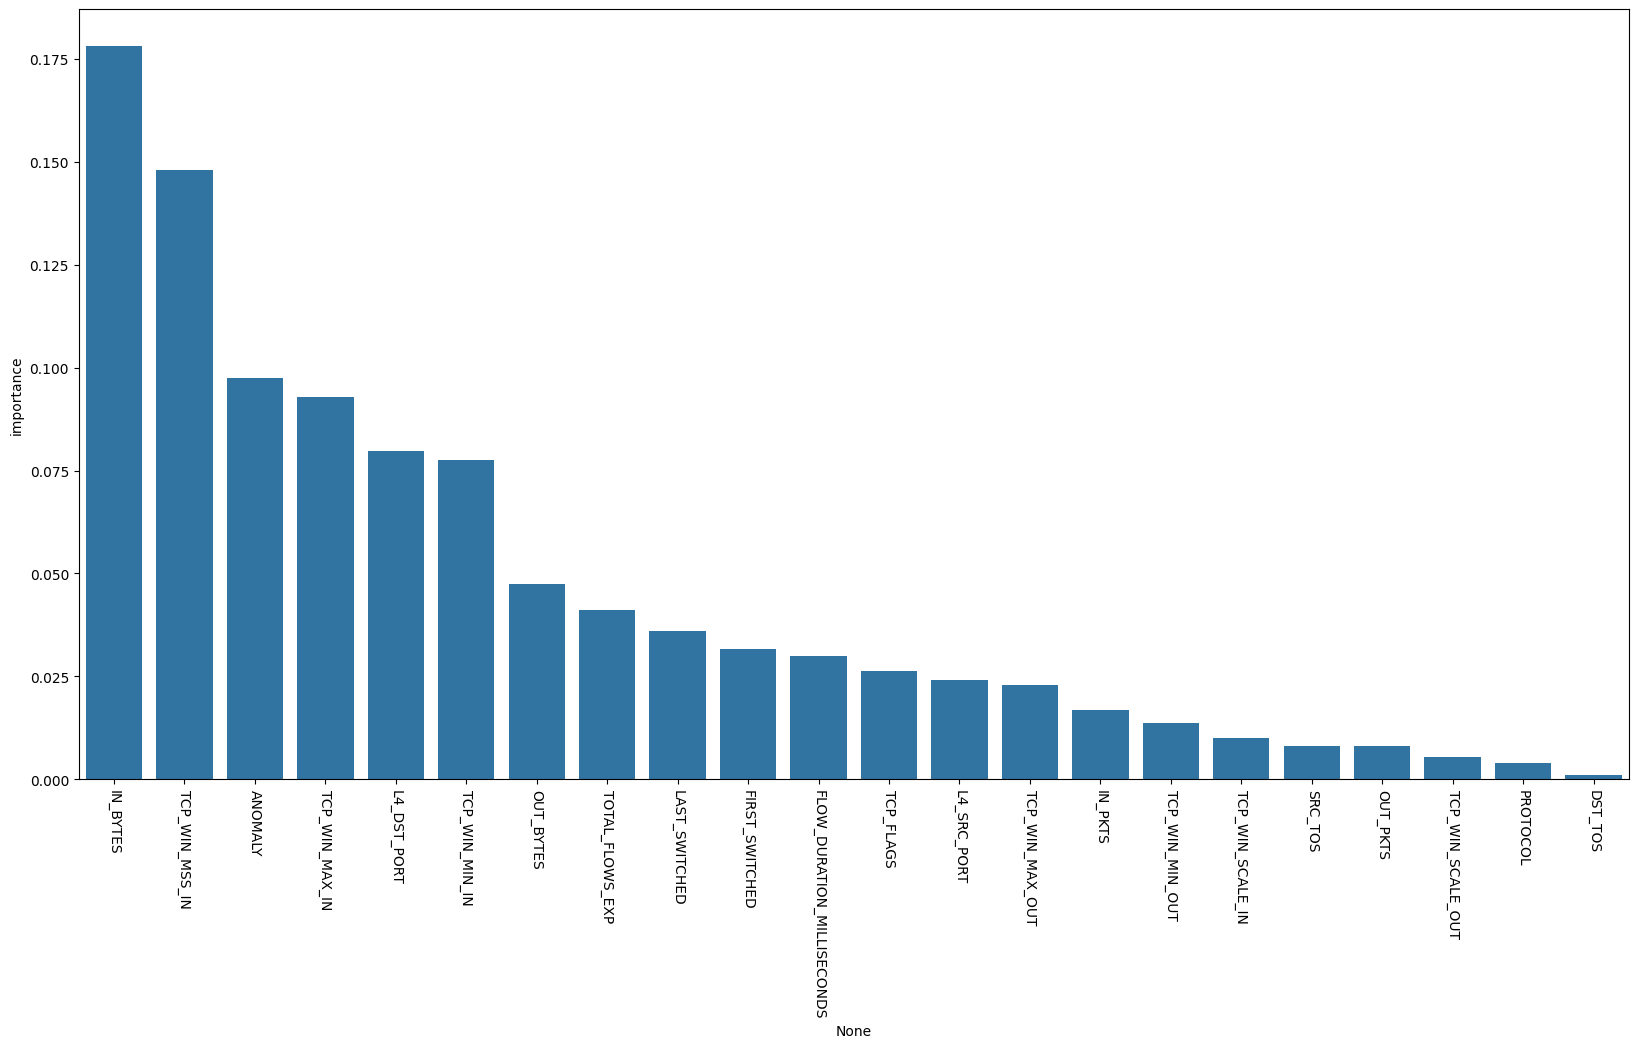

In [28]:
# Plot feature importance
plt.figure(figsize=(20, 10))
plt.xticks(rotation=-90)
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])

### 5.4. Select most important features

Select the most important features using the Random Forest classifier results

In [29]:
MIN_IMPORTANCE_THRESHOLD = 0.02

In [30]:
# Select all columns with importance > 0.02
COLUMNS = feature_importances[feature_importances['importance'] > MIN_IMPORTANCE_THRESHOLD].index
COLUMNS

Index(['IN_BYTES', 'TCP_WIN_MSS_IN', 'ANOMALY', 'TCP_WIN_MAX_IN',
       'L4_DST_PORT', 'TCP_WIN_MIN_IN', 'OUT_BYTES', 'TOTAL_FLOWS_EXP',
       'LAST_SWITCHED', 'FIRST_SWITCHED', 'FLOW_DURATION_MILLISECONDS',
       'TCP_FLAGS', 'L4_SRC_PORT', 'TCP_WIN_MAX_OUT'],
      dtype='object')

### 5.5. Reprepare the dataset with the selected features

#### 5.5.1. Split again the training set into training and validation sets (with new features)

In [31]:
X_train, X_val, y_train, y_val = split_maintain_distribution(
  train_df[COLUMNS],
  train_df['ALERT']
)

#### 5.5.2. Scale again the train and validation sets (with new features)

In [32]:
# Fix scaler on train set
scaler = StandardScaler()
fitter = scaler.fit(X_train)

# Scale train and validation sets
x_train_scaled = fitter.transform(X_train)
x_validation_scaled = fitter.transform(X_val)

# Convert to pandas dataframe
df_feat_train = pd.DataFrame(x_train_scaled, columns=X_train.columns)
df_feat_validation = pd.DataFrame(x_validation_scaled, columns=X_val.columns)

#### 5.5.3. Scale also the test set (with new features)

In [33]:
# No target variable, so no need to split the fit and transform
x_test_scaled = StandardScaler().fit_transform(test_df[COLUMNS])
# Convert to pandas dataframe
df_feat_test = pd.DataFrame(x_test_scaled, columns=test_df[COLUMNS].columns)

## 7. Model Training

In this section we will train different models and compare their results. We will use the following models:

* K-Nearest Neighbors (KNN)
* Support Vector Machine (SVM) with RBF kernel (Radial Basis Function)
  * SVC
  * SVC with PCA (Principal Component Analysis) pipeline
* Bagging Classifier (SVC with RBF kernel)
* Random Forest Classifier
* Neural Network (MLPClassifier)

In [102]:
label_mapping = {0: 'Denial of Service', 1: 'Malware', 2: 'None', 3: 'Port Scanning'}

# Convert numerical predictions to string labels using the mapping
predictions_str = np.vectorize(label_mapping.get)(predictions)

### 7.1. KNN Classifier training

We can notice that the model is excessively precise, with a precision of 1.0 with any kind of attack. This is probably due to the fact that the dataset is highly imbalanced, with the majority of the flows being normal (no attack detected). We can also observe that also the number of malware attacks is very low, compared to the other attacks.

#### 7.1.1 Finding the best K hyperparameter for KNN

To find the best K hyperparameter for KNN, we will use the **validation set** to find the best K value. We will then use this K value to train the model on the **training set** and evaluate it on the **test set**.

In [36]:
# Find best K using GridSearchCV
MAX_DEGREE = 10

k_range = list(range(1, MAX_DEGREE+1))
param_grid = dict(n_neighbors=k_range)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(x_train_scaled, y_train)

# Print information about the model
print(f"Best k: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

Best k: {'n_neighbors': 1}
Best score: 0.9979945269355778


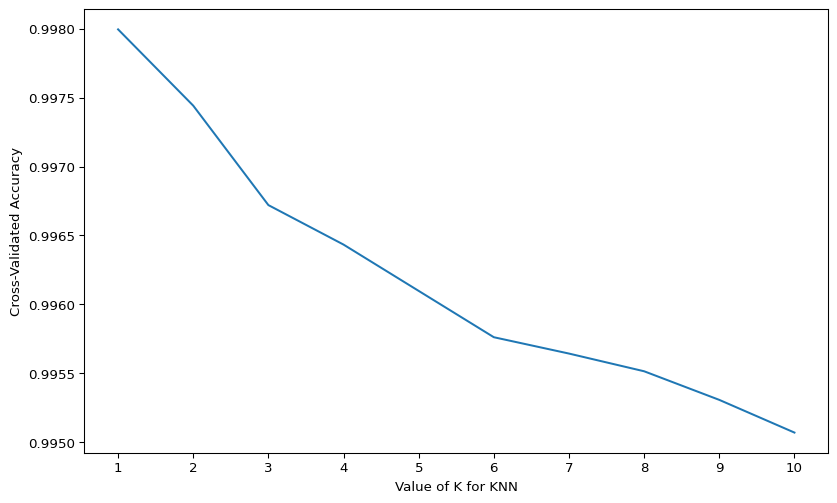

In [37]:
# Plot results
plt.figure(num=0, dpi=96, figsize=(10, 6))
plt.plot(k_range, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.show()

By looking at the graphical outcome, the best parameter for KNN is **K = 1**. Since this value would lead to overfitting, we will use the first odd number after 1, which is **K = 3**.

This outcome is not surprising since the training and validation sets are coming probably from the same network and the same hosts, so the flows are very similar to each other. This means that the best way to test our model is to use the **test set**.

#### 7.1.2. Fit model with best K hyperparameter + make predictions

In [38]:
# Create a KNN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3) # 3 = view note above
# Fit the classifier to the data
knn.fit(x_train_scaled, y_train)
# Make predictions on validation set
predictions = knn.predict(x_validation_scaled)

#### 7.1.3. Model evaluation based on validation set predictions

In [39]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.94      1.00      0.97       303
          Malware       1.00      1.00      1.00         4
             None       1.00      1.00      1.00     21978
    Port Scanning       0.98      1.00      0.99      3021

         accuracy                           1.00     25306
        macro avg       0.98      1.00      0.99     25306
     weighted avg       1.00      1.00      1.00     25306



<Axes: >

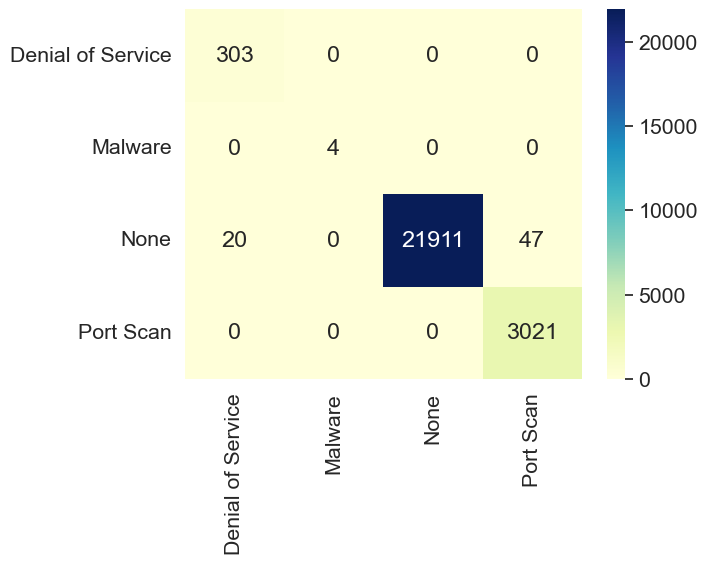

In [40]:
# Rename the columns and index for the confusion matrix
cmat = confusion_matrix(y_val, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

In [103]:
f1_scores = {}
f1_scores['KNN'] = f1_score(y_val, predictions_str, average='weighted')

#### 7.1.4. KNN predictions on test set

Unfortunately, the test set doesn't include the target variable, so we can't evaluate the model on it. We can only evaluate the model on the validation set.

C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\983840576.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


None                 53915
Port Scanning         7621
Denial of Service      779
Malware                  5
dtype: int64

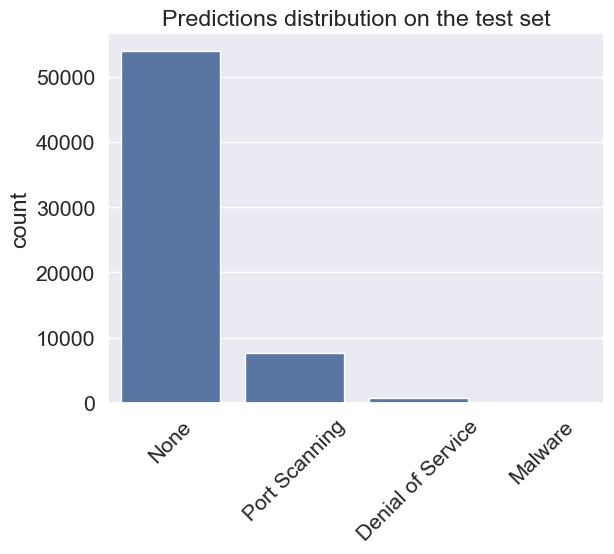

In [41]:
# Prediction on the test set
predictions = knn.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

### 7.2. Support Vector Machine Classifier (SVC) training

Support Vector Machine (SVM) is a supervised machine learning algorithm that can be used for both classification or regression challenges. However, it is mostly used in classification problems. In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.

#### 7.2.1 Only SVC model training

##### 7.2.1.1. Grid search to find best hyperparameters for SVC

In [42]:
# Create grid search parameters
param_grid = {
  'C': [0.1, 1, 10],
  'gamma': [1, 0.1, 0.01],
}

# Create grid search
svc_grid = GridSearchCV(
  SVC(kernel="rbf"),
  param_grid,
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1, # Use all cores
)

# Fit grid search
svc_grid.fit(x_train_scaled, y_train)

# Print information about the model
print(f"Best params: {svc_grid.best_params_}")
print(f"Best score: {svc_grid.best_score_}")

Best params: {'C': 10, 'gamma': 1}
Best score: 0.9976092388115154


##### 7.2.1.2. Create model with best parameters + fit model

In [44]:
# Create SVM with best parameters
svc = SVC(
  kernel='rbf',
  C=svc_grid.best_params_['C'],
  gamma=svc_grid.best_params_['gamma'],
)
svc.fit(x_train_scaled, y_train)

SVC(C=10, gamma=1)

##### 7.2.1.3. Make predictions

In [45]:
# Make predictions on validation set
predictions = svc.predict(x_validation_scaled)

##### 7.2.1.4. Model evaluation

In [46]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.97      1.00      0.99       303
          Malware       1.00      1.00      1.00         4
             None       1.00      1.00      1.00     21978
    Port Scanning       0.99      1.00      0.99      3021

         accuracy                           1.00     25306
        macro avg       0.99      1.00      0.99     25306
     weighted avg       1.00      1.00      1.00     25306



<Axes: >

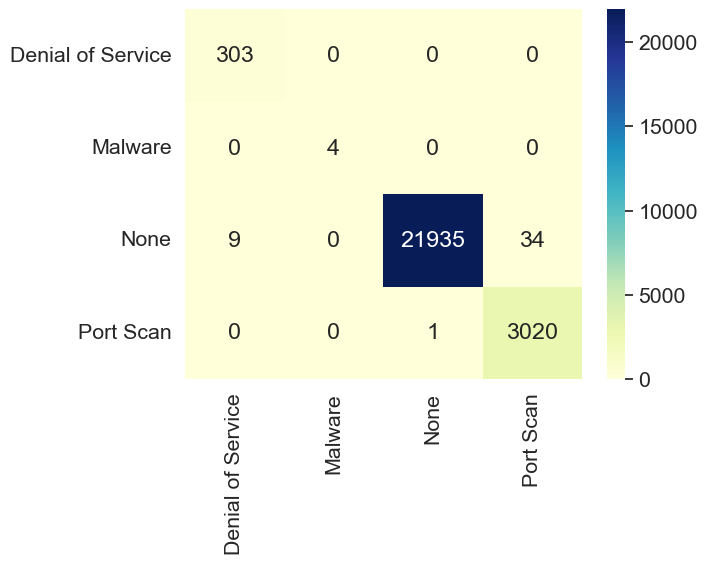

In [47]:
# Rename the columns and index for the confusion matrix
cmat = confusion_matrix(y_val, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

In [104]:
f1_scores['SVM'] = f1_score(y_val, predictions_str, average='weighted')

##### 7.2.1.5. SVC model predictions on test set

C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\808094574.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


None                 53982
Port Scanning         7584
Denial of Service      749
Malware                  5
dtype: int64

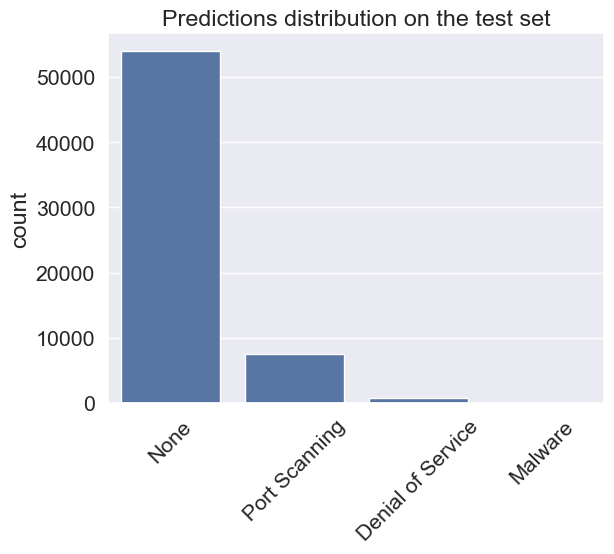

In [48]:
# Prediction on the test set
predictions = svc.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

#### 7.2.2. PCA + SVC model training

##### 7.2.2.1. Create pipeline

In [69]:
# Create the two parameters
pca = PCA(whiten=True, random_state=42) # PCA (Principal Component Analysis)
svc = SVC(kernel='rbf', class_weight='balanced') # SVC (Support Vector Classification)

# Create pipeline
model = make_pipeline(pca, svc)

##### 7.2.2.2. Grid search to find the best parameters for PCA and SVC

In [70]:
# Generate a valid n_components range (from 5 to maximum number of features)
n_features = x_train_scaled.shape[1]
n_components = np.arange(5, n_features, 3)

param_grid = {
  'pca__n_components': n_components,
  'svc__C': [100, 500, 1000, 5000],
  'svc__gamma': [0.1, 1, 10]
}

# Grid search 
pipeline_grid = GridSearchCV(
    model,
    param_grid,
    cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
    n_jobs=-1 # Use all cores
)
pipeline_grid.fit(x_train_scaled, y_train)

# Print information about the model
print(f"Best params: {pipeline_grid.best_params_}")
print(f"Best score: {pipeline_grid.best_score_}")

Best params: {'pca__n_components': 11, 'svc__C': 100, 'svc__gamma': 10}
Best score: 0.9985082421240482


##### 7.2.2.3. Create pipeline with best parameters + fit model

In [71]:
# Now, create the desired pipeline
pca = PCA(
  n_components=pipeline_grid.best_params_['pca__n_components'],
  whiten=True,
  random_state=42
)
svc = SVC(kernel='rbf',
  class_weight='balanced',
  # Use the best parameters found by the grid search
  C=pipeline_grid.best_params_['svc__C'],
  gamma=pipeline_grid.best_params_['svc__gamma']
)
model = make_pipeline(pca, svc)
model.fit(x_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=11, random_state=42, whiten=True)),
                ('svc', SVC(C=100, class_weight='balanced', gamma=10))])

##### 7.2.2.4. Make predictions

In [72]:
# Make predictions on validation set
predictions = model.predict(x_validation_scaled)

##### 7.2.2.5. Model evaluation

In [73]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.99      1.00      1.00       303
          Malware       1.00      0.75      0.86         4
             None       1.00      1.00      1.00     21978
    Port Scanning       0.99      1.00      1.00      3021

         accuracy                           1.00     25306
        macro avg       1.00      0.94      0.96     25306
     weighted avg       1.00      1.00      1.00     25306



<Axes: >

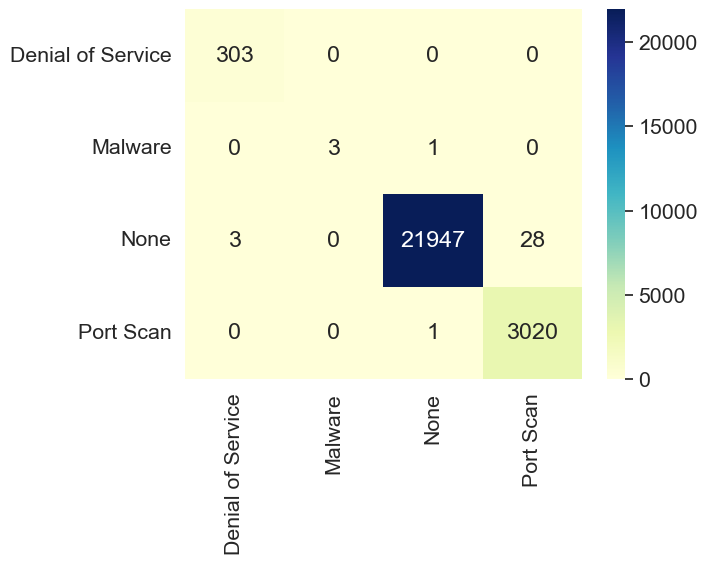

In [74]:
# Rename the columns and index for the confusion matrix
cmat = confusion_matrix(y_val, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

In [105]:
f1_scores['Pipeline SVC'] = f1_score(y_val, predictions_str, average='weighted')

##### 7.2.2.6. SVC+PCA pipeline model predictions on test set

C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\674104990.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


None                 53998
Port Scanning         7570
Denial of Service      748
Malware                  4
dtype: int64

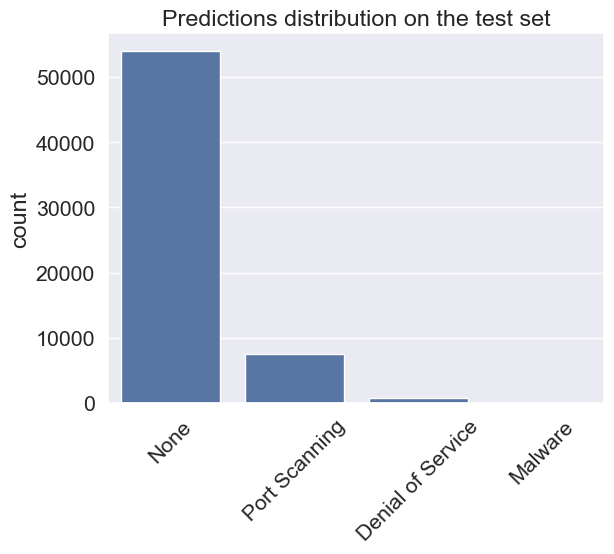

In [75]:
# Prediction on the test set
predictions = model.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

### 7.3. Bagging Classifier (SVC based) training

Bagging Classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

#### 7.3.1. Create model using best SVC parameters + fit model

In [50]:
svc = SVC(kernel='rbf',
  class_weight='balanced',
  C=svc_grid.best_params_['C'],
  gamma=svc_grid.best_params_['gamma']
)

clf = BaggingClassifier(
  svc,
  n_estimators=30,
  n_jobs=-1, # Use all cores
  random_state=42
)
clf.fit(x_train_scaled, y_train)


BaggingClassifier(base_estimator=SVC(C=10, class_weight='balanced', gamma=1),
                  n_estimators=30, n_jobs=-1, random_state=42)

#### 7.3.2. Make predictions

In [51]:
predictions = clf.predict(x_validation_scaled)

#### 7.3.3. Model evaluation

In [52]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.92      1.00      0.96       303
          Malware       1.00      1.00      1.00         4
             None       1.00      1.00      1.00     21978
    Port Scanning       0.98      1.00      0.99      3021

         accuracy                           1.00     25306
        macro avg       0.98      1.00      0.99     25306
     weighted avg       1.00      1.00      1.00     25306



<Axes: >

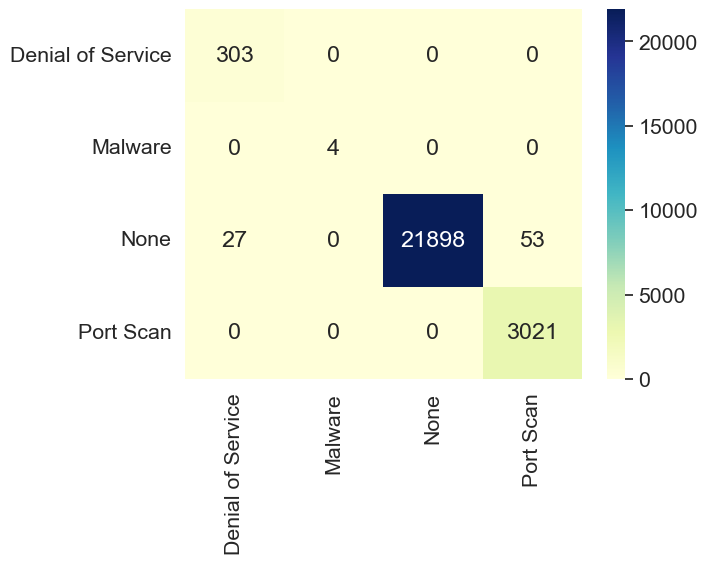

In [53]:
# Rename the columns and index for the confusion matrix
cmat = confusion_matrix(y_val, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

In [106]:
f1_scores['Bagging SVC'] = f1_score(y_val, predictions_str, average='weighted')

#### 7.5.5. Bagging Classifier predictions on test set

C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\3725699281.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


None                 53853
Port Scanning         7633
Denial of Service      829
Malware                  5
dtype: int64

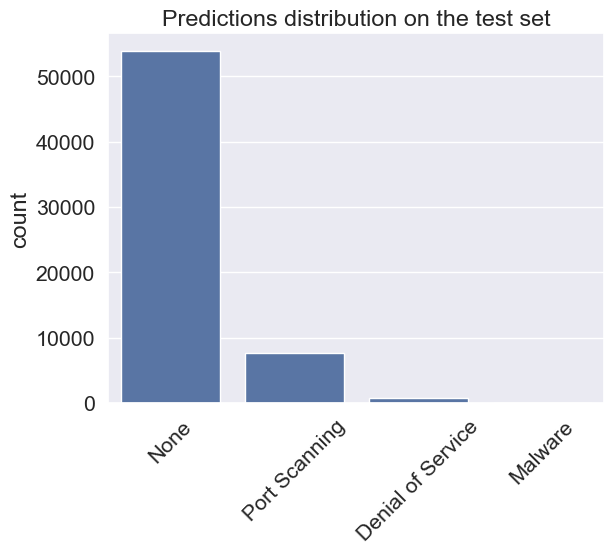

In [54]:
# Prediction on the test set
predictions = clf.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

### 7.4. Random Forest Classifier training

Random Forest is an ensemble method that combines multiple decision trees to create a more accurate model. It is a supervised learning algorithm that can be used for both classification and regression tasks.

#### 7.4.1. Grid search to find best hyperparameters for Random Forest

In [55]:
# Create random forest classifier
rfc = RandomForestClassifier()

# Create a dictionary of all values we want to test for n_estimators
parameters = {'n_estimators': [15, 20, 30, 40, 50, 100, 200]}

# Used to find the best n_estimators value to use to train the model
rfc_grid = GridSearchCV(
  rfc,
  parameters,
  scoring='accuracy',
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1 # Use all cores
)

# Fit model to data
rfc_grid.fit(x_train_scaled, y_train)

# Extract best params
print(f"Best params: {rfc_grid.best_params_}")
print(f"Best score: {rfc_grid.best_score_}")

Best params: {'n_estimators': 50}
Best score: 0.9997036242798609


#### 7.4.2. Create model with best parameters + fit model

In [56]:
rfc = RandomForestClassifier(n_estimators=rfc_grid.best_params_['n_estimators'])
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier(n_estimators=50)

In [58]:
x_train_scaled

array([[-0.01776972,  1.57726206,  3.02889227, ..., -0.55157452,
         0.71143602, -0.39160337],
       [-0.01557286,  1.57726206, -0.3301537 , ...,  1.03241952,
         1.20565425,  2.896058  ],
       [-0.01776972,  1.57726206,  3.02889227, ...,  0.76842051,
         0.71138397, -0.39160337],
       ...,
       [-0.01770818, -0.63025624, -0.3301537 , ..., -0.68357403,
         0.26333442, -0.39160337],
       [-0.01761397, -0.63025624, -0.3301537 , ..., -0.68357403,
        -2.19255799, -0.39160337],
       [-0.01775339, -0.63025624, -0.3301537 , ..., -0.68357403,
        -2.19255799, -0.39160337]])

#### 7.4.3. Make predictions

In [57]:
# Make predictions on validation set
predictions = rfc.predict(x_validation_scaled)

#### 7.4.4. Model evaluation

In [59]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00       303
          Malware       1.00      0.75      0.86         4
             None       1.00      1.00      1.00     21978
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00     25306
        macro avg       1.00      0.94      0.96     25306
     weighted avg       1.00      1.00      1.00     25306



<Axes: >

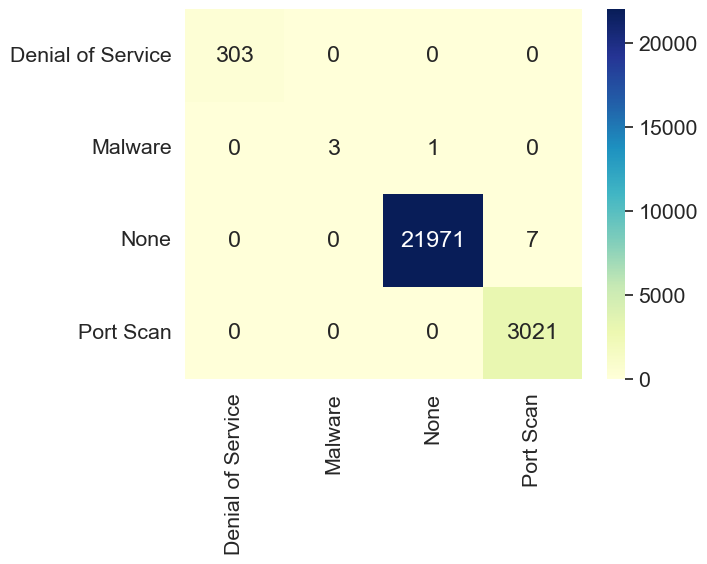

In [60]:
# Rename the columns and index for the confusion matrix
cmat = confusion_matrix(y_val, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

In [107]:
f1_scores['Random Forest'] = f1_score(y_val, predictions_str, average='weighted')

#### 7.5.5. Random Forest model predictions on test set

C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\2659482637.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


None             62182
Port Scanning      134
Malware              4
dtype: int64

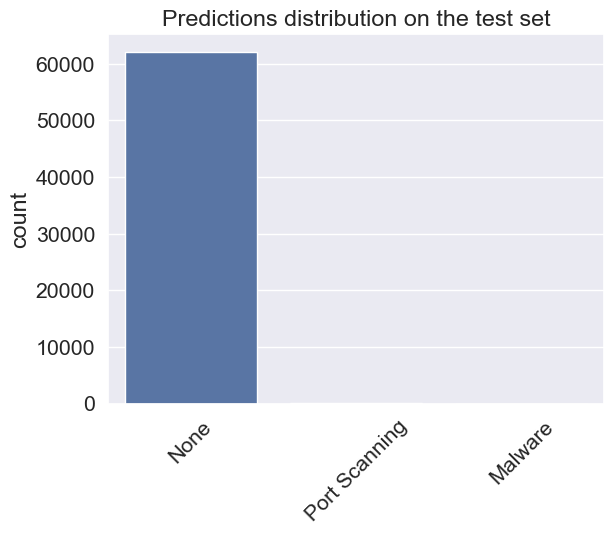

In [61]:
# Prediction on the test set
predictions = rfc.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

### 7.6. Neural Network classifier training

#### 7.6.1. Grid search to find best hyperparameters for Neural Network

In [62]:
# Create MLPClasifier
mlp = MLPClassifier(
  max_iter=500,
  random_state=42
)

# Grid search for MLPClassifier
parameters = {
  'hidden_layer_sizes': [(15,), (25,), (25, 25)],
  'activation': ['relu', 'tanh'],
  'alpha': [0.0001, 0.001],
  'solver': ['adam', 'lbfgs'],
  'learning_rate': ['constant', 'invscaling'],
}

mlp_grid = GridSearchCV(
  mlp,
  parameters,
  cv=2, # Only 2 folds because of the size of the dataset, otherwise it takes too long
  n_jobs=-1, # Use all cores
)

mlp_grid.fit(x_train_scaled, y_train)

C:\Users\aksha\miniconda3\envs\malware_detection\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=2, estimator=MLPClassifier(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(15,), (25,), (25, 25)],
                         'learning_rate': ['constant', 'invscaling'],
                         'solver': ['adam', 'lbfgs']})

In [63]:
# Extract best params
print(f"Best params: {mlp_grid.best_params_}")
print(f"Best score: {mlp_grid.best_score_}")

Best params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (25, 25), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best score: 0.9990318388327282


#### 7.6.2. Create model with best parameters + fit model

In [64]:
# Create MLPClassifier with best parameters
mlp = MLPClassifier(
  hidden_layer_sizes=mlp_grid.best_params_['hidden_layer_sizes'],
  activation=mlp_grid.best_params_['activation'],
  alpha=mlp_grid.best_params_['alpha'],
  solver=mlp_grid.best_params_['solver'],
  learning_rate=mlp_grid.best_params_['learning_rate'],
  max_iter=1000,
  random_state=42
)
mlp.fit(x_train_scaled, y_train)

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(25, 25),
              max_iter=1000, random_state=42, solver='lbfgs')

#### 7.6.3. Make predictions

In [65]:
# Make predictions on validation set
predictions = mlp.predict(x_validation_scaled)

#### 7.6.4. Model evaluation

In [66]:
# Print the classification report
print(classification_report(y_val, predictions))

                   precision    recall  f1-score   support

Denial of Service       0.98      1.00      0.99       303
          Malware       1.00      1.00      1.00         4
             None       1.00      1.00      1.00     21978
    Port Scanning       1.00      1.00      1.00      3021

         accuracy                           1.00     25306
        macro avg       0.99      1.00      1.00     25306
     weighted avg       1.00      1.00      1.00     25306



<Axes: >

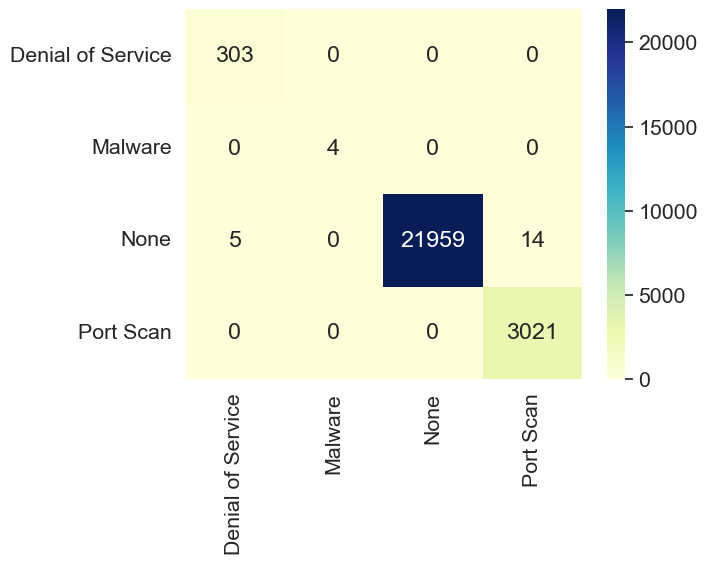

In [67]:
# Rename the columns and index for the confusion matrix
cmat = confusion_matrix(y_val, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'], columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4) # for label size
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')

In [108]:
f1_scores['MLP'] = f1_score(y_val, predictions_str, average='weighted')

#### 7.6.5. MLP classifier model predictions on test set

C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\2057250653.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels


None                 54293
Port Scanning         7260
Denial of Service      762
Malware                  5
dtype: int64

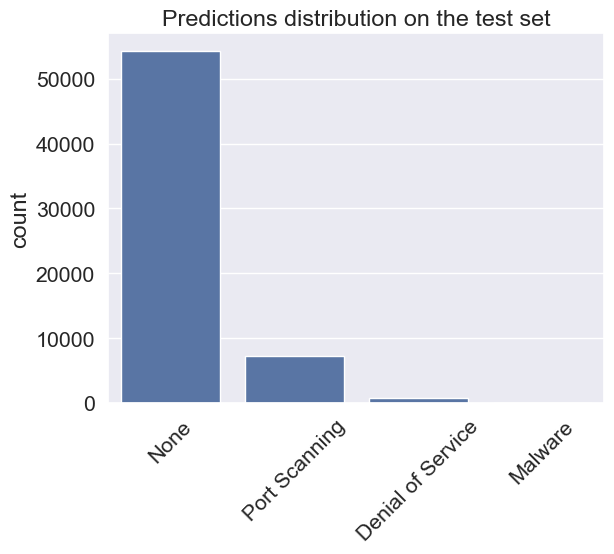

In [68]:
# Prediction on the test set
predictions = mlp.predict(x_test_scaled)

# Show the predictions on a histogram
fig = sns.countplot(x=predictions)
fig.set_title('Predictions distribution on the test set') # Set the title
fig.set_xticklabels(fig.get_xticklabels(), rotation=45) # Rotate x-labels
pd.Series(predictions).value_counts() # Print the predictions size per class

### 7.7. Boosting classifier training

#### 7.7.1. Label Encoding as XGBoost cant work with string outputs

In [82]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training labels (y_train)
y_train_encoded = label_encoder.fit_transform(y_train)

# If you have validation and test sets, apply the same transformation
y_val_encoded = label_encoder.transform(y_val)

#### 7.7.2. Grid search to find best hyperparameters

In [83]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,  # Prevent warnings related to label encoding
    eval_metric='mlogloss'     # Set evaluation metric (useful for multi-class classification)
)

# Grid search parameters for XGBoost
parameters = {
    'n_estimators': [50, 100],  # Number of boosting rounds
    'max_depth': [5, 8],         # Limit tree depth
    'learning_rate': [0.1, 0.01],  # Learning rate
    'gamma': [0, 0.1]            # Minimum loss reduction required for further partitioning
}

# Grid search for XGBoost
xgb_grid = GridSearchCV(
    xgb_model,
    parameters,
    cv=2,   # Only 2 folds because of dataset size (adjust as needed)
    n_jobs=-1,  # Use all cores
    verbose=1   # Verbose output to track progress
)

# Train the grid search model on the training set
xgb_grid.fit(x_train_scaled, y_train_encoded)


Fitting 2 folds for each of 16 candidates, totalling 32 fits


C:\Users\aksha\miniconda3\envs\malware_detection\lib\site-packages\xgboost\core.py:158: UserWarning: [03:08:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1], 'learning_rate': [0.1, 0.01],
                         'max_depth': [5, 8], 'n_estimators': [50, 100]},
             verbose=1)

In [84]:
# Print best hyperparameters found by grid search
print(f"Best params: {xgb_grid.best_params_}")
print(f"Best score: {xgb_grid.best_score_}")

Best params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
Best score: 0.9996443496043041


#### 7.7.3. Create model with best parameters + fit model

In [91]:
# Use the best parameters to reinitialize the model
xgb_model = xgb.XGBClassifier(
    **xgb_grid.best_params_,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",          # Metric for classification
    early_stopping_rounds=10          # Stops if no improvement over 10 rounds
)

# Fit the model with early stopping on a validation split
xgb_model.fit(
    x_train_scaled, y_train_encoded,
    eval_set=[(x_validation_scaled, y_val_encoded)],
    verbose=100,
)

[0]	validation_0-mlogloss:1.19435


C:\Users\aksha\miniconda3\envs\malware_detection\lib\site-packages\xgboost\core.py:158: UserWarning: [03:14:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-mlogloss:0.00102


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

#### 7.7.4. Make predictions

In [92]:
predictions = xgb_model.predict(x_validation_scaled)

#### 7.7.5. Model evaluation

In [94]:
# Print the classification report for model performance on validation data
print(classification_report(y_val_encoded, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       303
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00     21978
           3       1.00      1.00      1.00      3021

    accuracy                           1.00     25306
   macro avg       1.00      1.00      1.00     25306
weighted avg       1.00      1.00      1.00     25306



<Axes: >

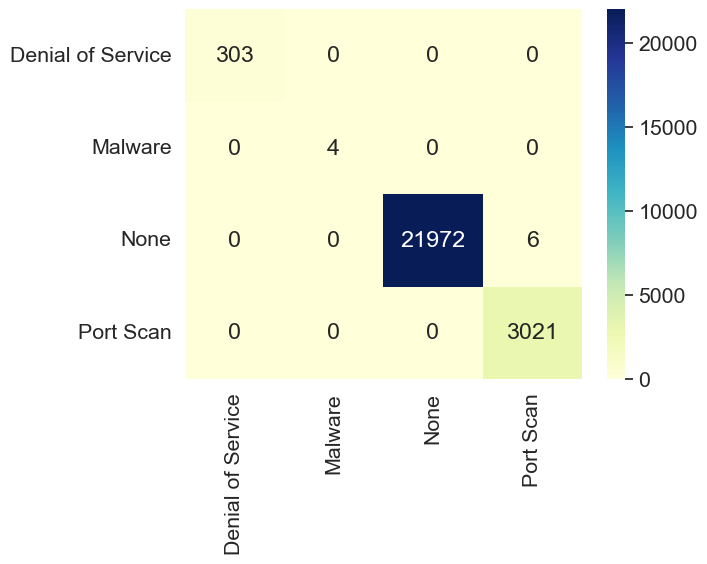

In [96]:
# Confusion matrix for validation set predictions
cmat = confusion_matrix(y_val_encoded, predictions)
cmat = pd.DataFrame(cmat, index=['Denial of Service', 'Malware', 'None', 'Port Scan'],
                    columns=['Denial of Service', 'Malware', 'None', 'Port Scan'])

# Use seaborn to visualize the confusion matrix
sns.set(font_scale=1.4)  # Adjust font scale for clarity
sns.heatmap(cmat, annot=True, fmt='d', cmap='YlGnBu')  # Plot heatmap with labels

In [109]:
f1_scores['XGBoost'] = f1_score(y_val, predictions_str, average='weighted')

#### 7.7.6. XGBoost classifier model predictions on test set

2    62312
1        8
dtype: int64


C:\Users\aksha\AppData\Local\Temp\ipykernel_8756\2092601114.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45)  # Rotate x-axis labels for readability


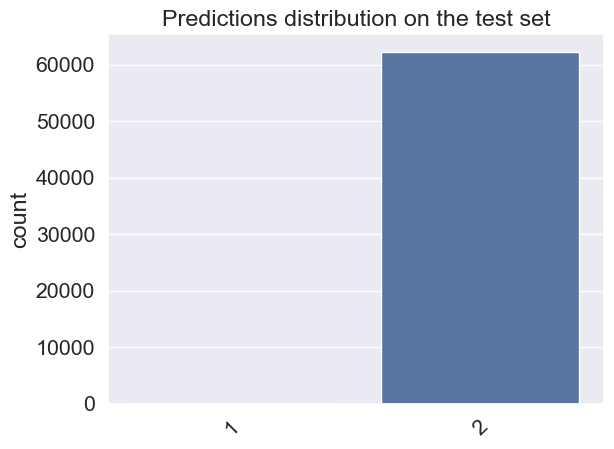

In [97]:
# Predictions on the test set
predictions_test = xgb_model.predict(x_test_scaled)

# Show the predictions distribution on a histogram
fig = sns.countplot(x=predictions_test)
fig.set_title('Predictions distribution on the test set')  # Title for histogram
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)  # Rotate x-axis labels for readability

# Print the predictions count per class in the test set
print(pd.Series(predictions_test).value_counts())

## 8. Comparative Analysis of Classification Models

In [110]:
# After all models have been evaluated, print the F1 score comparison
print("\nWeighted F1 Score Comparison Across Models:")
for model_name, f1 in f1_scores.items():
    print(f"{model_name}: {f1:.4f}")


Weighted F1 Score Comparison Across Models:
KNN: 0.9998
SVM: 0.9998
Pipeline SVC: 0.9998
Bagging SVC: 0.9998
Random Forest: 0.9998
MLP: 0.9998
XGBoost: 0.9998


### Explanation of Model Selection

The F1 scores obtained for each model are exceedingly high (around 0.9998) across all classes. This inflation in F1 scores can largely be attributed to an imbalanced dataset, where the "None" class constitutes the majority of labels. With such a class distribution, models can achieve high scores by primarily predicting the dominant class, leading to an inflated weighted F1 score that does not fully capture the true performance on minority classes (e.g., "Malware" or "Port Scanning").

Due to this imbalance, the F1 scores alone do not effectively distinguish between models. As an alternative metric, we utilize the grid search cross-validation scores obtained during training. These scores, which reflect model performance based on cross-validated grid search, provide a more robust basis for comparison.

Among all models, the Random Forest Classifier (RFC) demonstrated the highest cross-validated grid search score. Therefore, RFC is selected as the final model for this application.


#### Based on scores we use Random Forest Model

In [113]:
import joblib

# Save model with joblib
joblib.dump(rfc, 'models/rfc_model.joblib')

# Save scaler with joblib
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']